In [1]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install cmocean
import scipy as sci
from scipy import linalg
import timeit

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.available
mpl.style.use('seaborn-paper') 
import matplotlib.patches as mpatches

import torch
from torch import nn
from torch.autograd import Variable, Function
from torch.utils.data import DataLoader, Dataset

     |████████████████████████████████| 225kB 9.4MB/s 


In [4]:
X = np.load('/content/drive/MyDrive/Colab Notebooks/flow_cylinder.npy')
print(X.shape)

(151, 384, 199)


In [5]:
# Split into train and test set
Xsmall = X[0:100, :, :]
t, m, n = Xsmall.shape
    
Xsmall = Xsmall.reshape(100, -1)
Xsmall_test = X[100:151, :, :].reshape(51, -1)

In [6]:
Xsmall.shape

(100, 76416)

In [7]:
Xsmall = np.asarray(Xsmall)
Xsmall_test = np.asarray(Xsmall_test)
    
# get size
outputlayer_size = Xsmall.shape[1]
n_snapshots_train = Xsmall.shape[0]
n_snapshots_test = Xsmall_test.shape[0]

In [8]:
#Demean
Xmean = Xsmall.mean(axis=0)    
Xsmall -= Xmean
Xsmall_test -= Xmean

In [9]:
Xsmall.shape

(100, 76416)

In [10]:
Xmean.shape

(76416,)

In [11]:
np.random.seed(12345)
sensor_num = 5
n_snapshots_train, n_pix = Xsmall.shape
n_snapshots_test, _ = Xsmall_test.shape
m, n = 384, 199

mask = np.zeros((m,n))
theata = np.linspace(0, 2*np.pi, 300)
x_cord = np.round(36 * np.cos(theata)) + 0
y_cord = np.round(36 * np.sin(theata)) + 99
cords = np.vstack((x_cord,y_cord)).T
x_cord = np.unique(cords, axis=0)
idx = x_cord[:,0] > 0
x_cord = x_cord[idx,:]

idx = np.random.choice(range(x_cord.shape[0]), sensor_num, False)
x_cord = np.int64(x_cord[idx,:])

mask[x_cord[:,0], x_cord[:,1]] = 1
pivots = np.where(mask.reshape(-1) == 1)
pivots = np.asarray(pivots).ravel()


sensors = Xsmall[:, pivots].reshape(n_snapshots_train, sensor_num)
sensors_test = Xsmall_test[:, pivots].reshape(n_snapshots_test, sensor_num)
sensor_locations = pivots

In [12]:
pivots

array([2652, 4704, 5048, 6875, 7071])

In [13]:
def plot_flow_cylinder(Xsmall, sensor_locations, m, n, Xmean):
    import cmocean

    x2 = np.arange(0, 384, 1)
    y2 = np.arange(0, 199, 1)
    mX, mY = np.meshgrid(x2, y2)

    img = Xsmall[0,:]  + Xmean
    img = img.reshape(384,199)

    minmax = np.max(np.abs(img)) * 0.65
    plt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
    plt.contourf(mX, mY, img.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax, vmax=minmax)
    plt.contour(mX, mY, img.T, 80, colors='black', alpha=0.5, vmin=-minmax, vmax=minmax)
    im = plt.imshow(img.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
    
    wedge = mpatches.Wedge((0,99), 33, 270, 90, ec="#636363", color='#636363',lw = 5, zorder=200)
    im.axes.add_patch(p=wedge)    
    
    plt.tight_layout()
    plt.axis('off')
    
    ygrid = range(n)
    xgrid = range(m)
    yv, xv = np.meshgrid(ygrid, xgrid)
    
    x_sensors = xv.reshape(1, m*n)[:, sensor_locations]
    y_sensors = yv.reshape(1, m*n)[:, sensor_locations]

    plt.scatter(x_sensors, y_sensors, marker='.', color='#ff7f00', s=500, zorder=5)
    plt.title('Truth with sensor locations')      
    plt.show()

    img = Xsmall[0,:]  + Xmean
    img = img.reshape(384,199)

    plt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
    plt.contourf(mX, mY, img.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax, vmax=minmax)
    plt.contour(mX, mY, img.T, 80, colors='black', alpha=0.5, vmin=-minmax, vmax=minmax)
    im = plt.imshow(img.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)    
    wedge = mpatches.Wedge((0,99), 33, 270, 90, ec="#636363", color='#636363',lw = 5, zorder=200)
    im.axes.add_patch(p=wedge)    
        
    plt.title('Truth')      
    plt.tight_layout()
    plt.axis('off')
    plt.show()

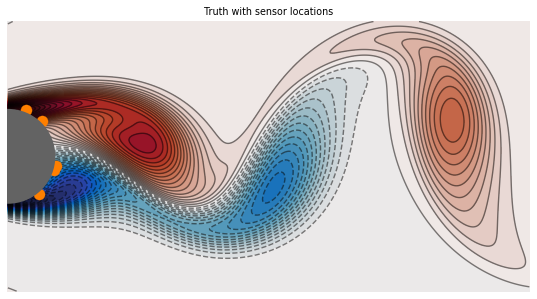

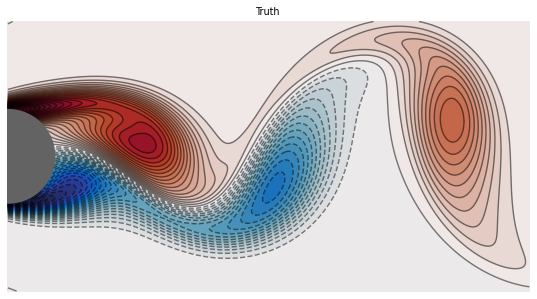

In [14]:
plot_flow_cylinder(Xsmall, sensor_locations, m, n, Xmean)

In [15]:
def add_channels(X):
    if len(X.shape) == 2:
        return X.reshape(X.shape[0], 1, -1)
    
    elif len(X.shape) == 3:
        return X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])
    
    else:
        return "dimenional error"

def model_from_name(name, outputlayer_size, n_sensors):
    if name == 'shallow_decoder':
        return shallow_decoder(outputlayer_size, n_sensors)  

    raise ValueError('model {} not recognized'.format(name))
    

class shallow_decoder(nn.Module):
    def __init__(self, outputlayer_size, n_sensors):
        super(shallow_decoder, self).__init__()
        
        self.n_sensors = n_sensors
        self.outputlayer_size = outputlayer_size
        
        self.learn_features = nn.Sequential(         
            nn.Linear(n_sensors, 40),
            nn.ReLU(True), 
            nn.BatchNorm1d(1),  
            )        
        
        self.learn_coef = nn.Sequential(            
            nn.Linear(40, 45),
            nn.ReLU(True),  
            nn.BatchNorm1d(1),  
            )

        self.learn_dictionary = nn.Sequential(
            nn.Linear(45, self.outputlayer_size),
            )
        

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)        

            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)    


    def forward(self, x):
        x = self.learn_features(x)
        x = self.learn_coef(x)
        x = self.learn_dictionary(x) 
        return x


In [16]:
#******************************************************************************
# Reshape data for pytorch into 4D tensor Samples x Channels x Width x Hight
#******************************************************************************
batch_size = 100
Xsmall = add_channels(Xsmall)
Xsmall_test = add_channels(Xsmall_test)
sensors = add_channels(sensors)
sensors_test = add_channels(sensors_test)

# transfer to tensor 
sensors = torch.from_numpy(sensors)
Xsmall  = torch.from_numpy(Xsmall)

sensors_test = torch.from_numpy(sensors_test)
Xsmall_test  = torch.from_numpy(Xsmall_test)


#******************************************************************************
# Create Dataloader objects
#******************************************************************************
train_data = torch.utils.data.TensorDataset(sensors, Xsmall)
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)

#******************************************************************************
# Deep Decoder
#******************************************************************************
model = model_from_name('shallow_decoder', outputlayer_size = outputlayer_size, n_sensors = sensor_num)
model = model.cuda()

In [17]:
#******************************************************************************
# Optimizer and Loss Function
#******************************************************************************
num_epochs = 4000
batch_size = 100
learning_rate = 1e-2
weight_decay = 1e-4
learning_rate_change = 0.9
weight_decay_change  = 0.8
epoch_update = 100
alpha = 5e-8

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss().cuda()

def exp_lr_scheduler(optimizer, epoch, lr_decay_rate=0.8, weight_decay_rate=0.8, lr_decay_epoch=100):
    """Decay learning rate by a factor of lr_decay_rate every lr_decay_epoch epochs"""
    if epoch % lr_decay_epoch:
        return 
    
    # if args.optimizer == 'sgd':
    for param_group in optimizer.param_groups:
        param_group['lr'] *= lr_decay_rate
        param_group['weight_decay'] *= weight_decay_rate
    return 

In [18]:
#******************************************************************************
# Train: Initi model and set tuning parameters
#******************************************************************************
rerror_train = []
rerror_test = []

#******************************************************************************
# Start training
#******************************************************************************
t0 = timeit.default_timer()

for epoch in range(num_epochs):

  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.cuda(), target.cuda()
    data, target = Variable(data).float(), Variable(target).float()


    # ===================forward=====================
    model.train()
    output = model(data) 
    loss = criterion(output, target)

    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

        
    # ===================adjusted lr========================
    exp_lr_scheduler(optimizer, epoch, lr_decay_rate = learning_rate_change, 
                      weight_decay_rate = weight_decay_change, 
                      lr_decay_epoch = epoch_update)
            


if epoch % 500 == 0:
  print('********** Epoche %s **********' %( epoch))
  rerror_train.append(error_summary(sensors, Xsmall, n_snapshots_train, model.eval(), Xmean, 'training'))
  rerror_test.append(error_summary(sensors_test, Xsmall_test, n_snapshots_test, model.eval(), Xmean, 'testing'))

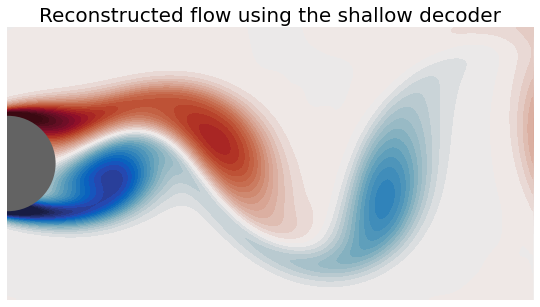

In [19]:
def plot_flow_cyliner_2(img_epoch, m, n, epoch, Xmean):
    import cmocean

    x2 = np.arange(0, 384, 1)
    y2 = np.arange(0, 199, 1)
    mX, mY = np.meshgrid(x2, y2)

    img_epoch += Xmean.reshape(m,n)

    minmax = np.max(np.abs(img_epoch)) * 0.65
    plt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
    im = plt.imshow(img_epoch.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
    plt.contourf(mX, mY, img_epoch.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax, vmax=minmax)
    
    wedge = mpatches.Wedge((0,99), 33, 270, 90, ec="#636363", color='#636363',lw = 5)
    im.axes.add_patch(p=wedge)    
        
    #plt.title('Epoch number ' + str(epoch), fontsize = 20 )
    plt.axis('off')
    plt.title('Reconstructed flow using the shallow decoder',fontsize=20)          
    plt.tight_layout()
    plt.show()
    plt.close()

#******************************************************************************
# Reconstructed flow field
#******************************************************************************
model.eval()
dataloader_temp = iter(DataLoader(sensors_test, batch_size = n_snapshots_test))
output_temp = model(Variable(dataloader_temp.next()).float().cuda())

plot_flow_cyliner_2(output_temp.cpu().data.numpy()[0,:,:].reshape(m,n), m, n, epoch, Xmean)

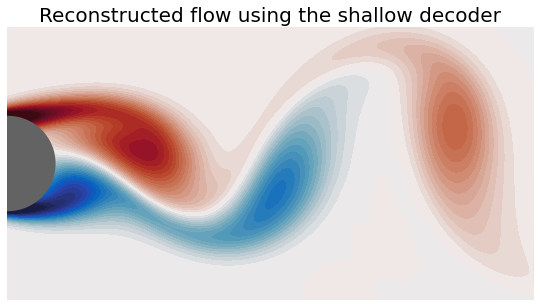

In [20]:
#******************************************************************************
# Reconstructed flow field
#******************************************************************************
model.eval()
dataloader_temp = iter(DataLoader(sensors, batch_size = n_snapshots_train))
output_temp = model(Variable(dataloader_temp.next()).float().cuda())

plot_flow_cyliner_2(output_temp.cpu().data.numpy()[0,:,:].reshape(m,n), m, n, epoch, Xmean)

In [21]:
def plot_spectrum(sensors, Xsmall, sensors_test, Xsmall_test,
                  n_snapshots, n_snapshots_test,
                  model, Xmean, sensor_locations, plotting, train_or_test='training'):
    from torch.autograd import Variable, Function
    from torch.utils.data import DataLoader, Dataset
    
    dataloader_temp = iter(DataLoader(sensors, batch_size = n_snapshots))
    output_temp = model(Variable(dataloader_temp.next()).float().cuda())
    tt, _, mt = output_temp.shape
    #        
    redata = output_temp.cpu().data.numpy().reshape(tt, mt)
    Xsmall_temp = Xsmall.data.numpy().reshape(tt, mt)    
    
    u, s, v = np.linalg.svd(Xsmall_temp.T, 0)
    _, s2, _ = np.linalg.svd(redata.T, 0)
       
    plt.figure(facecolor="white",  figsize=(10.0, 6.5),  edgecolor='k')
    plt.loglog(np.arange(len(s))+1, s, label='True spectrum', 
               marker= "o", lw=6, c='k', markersize=15)
        
    plt.loglog(np.arange(len(s2))+1, s2, label='Shallow Decoder', 
               marker= "o", c='#de2d26', lw=4, markersize=6)
    
    # Linear reconstruction using PCA
    n_sensors = len(sensor_locations)
    linear_coef = (np.linalg.pinv(u[sensor_locations, 0:n_sensors])).dot(sensors.cpu().data.numpy().reshape(tt, n_sensors).T)    
    redata_linear = (u[:,0:n_sensors].dot(linear_coef)).T
        
    
    _, s3, _ = np.linalg.svd(redata_linear, 0)
     
    plt.loglog(np.arange(len(s3))+1, s3, '--', label='POD', marker= "s",
               c='#3182bd', lw=4, markersize=6)
    
    
    plt.tick_params(axis='x', labelsize=22) 
    plt.tick_params(axis='y', labelsize=22) 
    #plt.locator_params(axis='y', nbins=4)
    #plt.locator_params(axis='x', nbins=4)
    
    plt.ylabel('Magnitude', fontsize=28)
    plt.xlabel('Number of singular value', fontsize=28)
    plt.grid(False)
    #plt.yscale("log")
    #ax[0].set_ylim([0.01,1])
    plt.legend(fontsize=22)
    plt.tight_layout()  
    plt.show()
        
    dataloader_temp = iter(DataLoader(sensors_test, batch_size = n_snapshots_test))
    output_temp = model(Variable(dataloader_temp.next()).float().cuda())
    tt, _, mt = output_temp.shape
    #        
    redata = output_temp.cpu().data.numpy().reshape(tt, mt)
    Xsmall_temp = Xsmall_test.data.numpy().reshape(tt, mt)    
    
    _, s, _ = np.linalg.svd(Xsmall_temp.T, 0)
    _, s2, _ = np.linalg.svd(redata.T, 0)
     
    plt.figure(facecolor="white",  figsize=(10.0, 6.5),  edgecolor='k')
    plt.loglog(np.arange(len(s))+1, s, 
               marker= "o",lw=6, c='k', label='True spectrum', markersize=15)
    #plt.scatter(np.log10(np.arange(len(s))+1), np.log10(s), label='True spectrum', marker= "D", s=80 )
        
    plt.loglog(np.arange(len(s))+1, s2, 
               marker= "o", label='Shallow Decoder', c='#de2d26', lw=4, markersize=6)
    #plt.scatter(np.log10(np.arange(len(s2))+1), np.log10(s2), label='Shallow Decoder', c='#de2d26', lw=3 )
    
    # Linear reconstruction using PCA
    n_sensors = len(sensor_locations)
    linear_coef = (np.linalg.pinv(u[sensor_locations, 0:n_sensors])).dot(sensors_test.cpu().data.numpy().reshape(tt, n_sensors).T)    
    redata_linear = (u[:,0:n_sensors].dot(linear_coef)).T
        
    _, s3, _ = np.linalg.svd(redata_linear, 0)
     
    plt.loglog(np.arange(len(s))+1, s3, '--',
               label='POD', marker= "s", c='#3182bd', lw=4, markersize=6)
    #plt.scatter(np.log10(np.arange(len(s3))+1), np.log10(s3))
    
    plt.tick_params(axis='x', labelsize=22) 
    plt.tick_params(axis='y', labelsize=22) 
    #plt.locator_params(axis='y', nbins=4)
    #plt.locator_params(axis='x', nbins=4)
    
    plt.ylabel('Magnitude', fontsize=28)
    plt.xlabel('Number of singular value', fontsize=28)
    plt.grid(False)
    #plt.yscale("log")
    #ax[0].set_ylim([0.01,1])
    plt.legend(fontsize=22)
    plt.tight_layout()  
    plt.show()

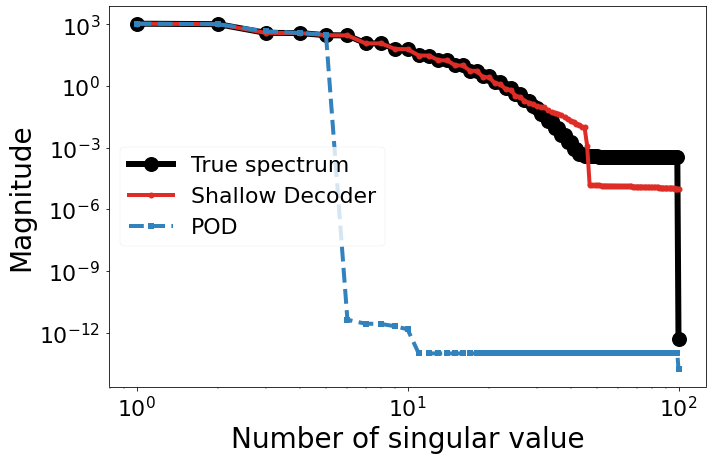

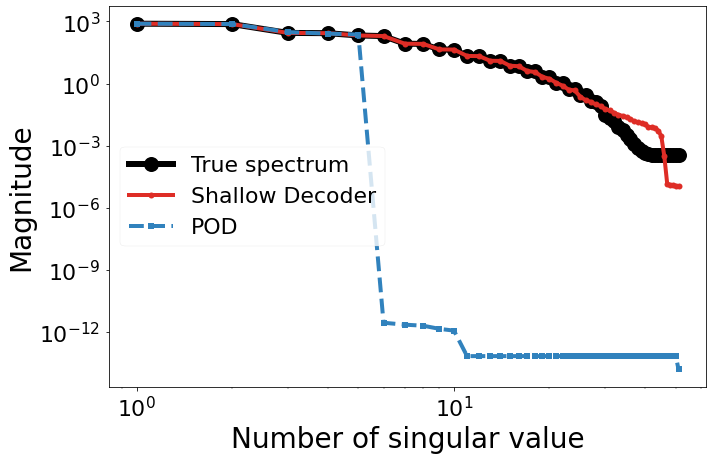

In [22]:
plot_spectrum(sensors, Xsmall, sensors_test, Xsmall_test, n_snapshots_train, 
              n_snapshots_test,model, Xmean, sensor_locations, 
              plotting = True, train_or_test='training')

In [23]:
def plot_flow_cyliner_pod(Xsmall, sensors, Xmean, sensor_locations, m, n):
    import cmocean

    x2 = np.arange(0, 384, 1)
    y2 = np.arange(0, 199, 1)
    mX, mY = np.meshgrid(x2, y2)
    
    tt, _, mt = Xsmall.shape
    Xsmall_temp = Xsmall.data.numpy().reshape(tt, mt)    
    u, s, v = np.linalg.svd(Xsmall_temp.T, 0)
       
    
    # Linear reconstruction using PCA - Train
    n_sensors = len(sensor_locations)
    linear_coef = (np.linalg.pinv(u[sensor_locations, 0:n_sensors])).dot(sensors.cpu().data.numpy().reshape(tt, n_sensors).T)    
    redata_linear = (u[:,0:n_sensors].dot(linear_coef)).T

    img_epoch = redata_linear[0,:].reshape(m,n)
    img_epoch += Xmean.reshape(m,n)
     
    minmax = np.max(np.abs(img_epoch)) * 0.65
    plt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
    im = plt.imshow(img_epoch.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
    plt.contourf(mX, mY, img_epoch.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax, vmax=minmax)
    
    
    wedge = mpatches.Wedge((0,99), 33, 270, 90, ec="#636363", color='#636363',lw = 5)
    im.axes.add_patch(p=wedge)    
        
    plt.title('Epoch number ' + str(epoch), fontsize = 20)
    plt.axis('off')
    plt.title('Reconstructed flow using POD',fontsize=20)      
    plt.tight_layout()
    plt.show()


        

def plot_flow_cyliner_regularized_pod(Xsmall, sensors, Xmean, sensor_locations, m, n, alpha):
    import cmocean
    from sklearn import linear_model

    x2 = np.arange(0, 384, 1)
    y2 = np.arange(0, 199, 1)
    mX, mY = np.meshgrid(x2, y2)
    
    tt, _, mt = Xsmall.shape
    Xsmall_temp = Xsmall.data.numpy().reshape(tt, mt)    
    u, s, v = np.linalg.svd(Xsmall_temp.T, 0)
       
    
    # Linear reconstruction using PCA - Train
    n_sensors = len(sensor_locations)
    reg = linear_model.Ridge(alpha=alpha, fit_intercept=False, normalize=False)
    reg.fit(u[sensor_locations, 0:n_sensors], sensors.cpu().data.numpy().reshape(tt, n_sensors).T)
    redata_linear = (u[:,0:n_sensors].dot(reg.coef_.T)).T

    img_epoch = redata_linear[0,:].reshape(m,n)
    img_epoch += Xmean.reshape(m,n)
     

    minmax = np.max(np.abs(img_epoch)) * 0.65
    plt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
    im = plt.imshow(img_epoch.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
    plt.contourf(mX, mY, img_epoch.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax, vmax=minmax)
    wedge = mpatches.Wedge((0,99), 33, 270, 90, ec="#636363", color='#636363',lw = 5)
    im.axes.add_patch(p=wedge)    
        
    plt.title('Epoch number ' + str(epoch), fontsize = 20)
    plt.axis('off')
    plt.title('Reconstructed flow using POD Plus',fontsize=20)          
    plt.tight_layout()
    plt.show()
 

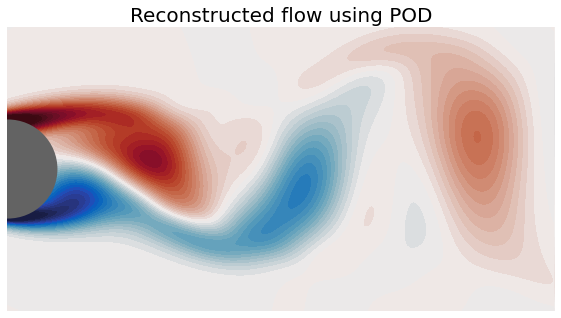

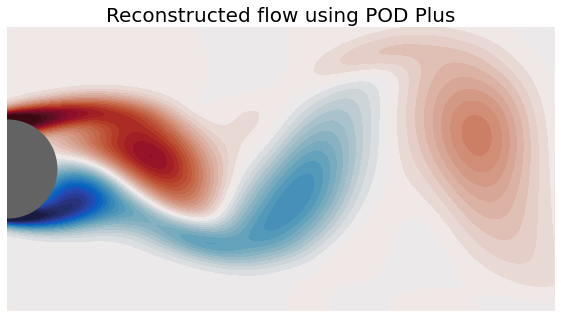

In [24]:
plot_flow_cyliner_pod(Xsmall, sensors, Xmean, sensor_locations, m, n)
plot_flow_cyliner_regularized_pod(Xsmall, sensors, Xmean, sensor_locations, m, n, alpha)